In [45]:
import tensorflow as tf
from tensorflow import keras

from nn import datasets, models
from hstar import gghzz, c6, msq
from hzz import zpair, angles

import numpy as np
import matplotlib.pyplot as plt

import json, os

from sklearn.preprocessing import StandardScaler

In [46]:
SEED=373485

JOBS_DIR='jobs/'
CONFIG_FILE=JOBS_DIR + 'train-single-SIG/job.config'

In [47]:
config=None
scaler_config=None

with open(CONFIG_FILE, 'r') as config_file:
    config, scaler_config  = json.loads(''.join(config_file.readlines()))

print(config)

{'sample_dir': '../..', 'output_dir': 'train-single-SIG', 'learning_rate': 1e-05, 'batch_size': 32, 'sig': True, 'int': False, 'num_events': 300000, 'num_layers': 10, 'num_nodes': 2000, 'epochs': 100, 'c6_values': [-10.0]}


In [48]:
sample = gghzz.Process(  
    (1.4783394, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_all_new.csv'), 110000),
    (0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4e_all_new.csv'), 110000),
    (0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4m_all_new.csv'), 110000)
)

sample.events = sample.events[300000:]

In [49]:
z_chooser = zpair.ZPairChooser(bounds1=(50,115), bounds2=(50,115), algorithm='leastsquare')
l1_1, l2_1, l1_2, l2_2 = sample.events.filter(z_chooser)

kin_variables = angles.calculate(l1_1, l2_1, l1_2, l2_2)

print(kin_variables.shape)

c6_values = np.array(config['c6_values'])

component = msq.Component.SIG if config['sig'] else msq.Component.SBI
component = msq.Component.INT if config['int'] else component

c6_mod = c6.Modifier(amplitude_component = component, c6_values = [-5,-1,0,1,5])
c6_weights, c6_prob = c6_mod.modify(sample=sample, c6=c6_values)

(29185, 8)


In [50]:
data = []

signal_weights = c6_prob
background_weights = tf.convert_to_tensor(sample[component].probabilities)[:,tf.newaxis]

for i in range(len(c6_values)):
    param = c6_values[i]

    sig_weights = tf.cast(signal_weights.T[i][:,tf.newaxis], tf.float32)
    bkg_weights = tf.cast(background_weights, tf.float32)

    data.append(tf.concat([kin_variables, tf.ones(kin_variables.shape[0])[:,tf.newaxis]*param, sig_weights, bkg_weights], axis=1))

test_data = tf.reshape(tf.convert_to_tensor(data), (tf.convert_to_tensor(data).shape[0]*tf.convert_to_tensor(data).shape[1], tf.convert_to_tensor(data).shape[2]))

print(test_data)

tf.Tensor(
[[-9.94998276e-01  9.93648112e-01  8.38303745e-01 ... -1.00000000e+01
   7.82971711e-07  1.13756630e-06]
 [-9.22650516e-01  6.95827484e-01 -7.49891639e-01 ... -1.00000000e+01
   1.24835033e-05  1.73798580e-05]
 [-8.30611110e-01  9.74011600e-01  9.75676060e-01 ... -1.00000000e+01
   7.15081043e-08  1.10178185e-07]
 ...
 [ 9.76370513e-01  9.98312116e-01  9.91939187e-01 ... -1.00000000e+01
   6.69746078e-06  9.69848861e-06]
 [-9.97107804e-01  9.99974489e-01  4.57654893e-01 ... -1.00000000e+01
   3.77443439e-06  5.94320863e-06]
 [ 9.99966383e-01  9.98995900e-01  9.98364449e-01 ... -1.00000000e+01
   1.15374905e-06  1.61805883e-06]], shape=(29185, 11), dtype=float32)


In [51]:
scaler = StandardScaler()

scaler.mean_ = scaler_config['scaler.mean_']
scaler.var_ = scaler_config['scaler.var_']
scaler.scale_ = scaler_config['scaler.scale_']

test_data = tf.concat([scaler.transform(test_data[:,:8]), test_data[:,8:]], axis=1)

print(test_data, test_data.shape)

mu = tf.reduce_sum(test_data[:,:8], axis=0)/test_data.shape[0]

print('Mean (after):', mu)

sigma = tf.math.reduce_std(test_data[:,:8], axis=0)

print('sigma (after):', sigma)

tf.Tensor(
[[-1.15929198e+00  6.00570679e-01  3.22767437e-01 ... -1.00000000e+01
   7.82971711e-07  1.13756630e-06]
 [-1.07583070e+00  6.64153844e-02 -2.52044630e+00 ... -1.00000000e+01
   1.24835033e-05  1.73798580e-05]
 [-9.69652772e-01  5.65351665e-01  5.68693638e-01 ... -1.00000000e+01
   7.15081043e-08  1.10178185e-07]
 ...
 [ 1.11490512e+00  6.08935773e-01  5.97808182e-01 ... -1.00000000e+01
   6.69746078e-06  9.69848861e-06]
 [-1.16172552e+00  6.11917377e-01 -3.58676463e-01 ... -1.00000000e+01
   3.77443439e-06  5.94320863e-06]
 [ 1.14212561e+00  6.10162199e-01  6.09310746e-01 ... -1.00000000e+01
   1.15374905e-06  1.61805883e-06]], shape=(29185, 11), dtype=float32) (29185, 11)
Mean (after): tf.Tensor(
[-0.00710394  0.01101229  0.00272672 -0.00071538 -0.00425187  0.03751875
  0.05785553 -0.02887887], shape=(8,), dtype=float32)
sigma (after): tf.Tensor(
[1.002885  0.9918818 1.001583  1.0020041 1.004557  1.0477242 1.0535675
 0.9247573], shape=(8,), dtype=float32)


In [52]:
model = keras.models.load_model(os.path.join(JOBS_DIR, config['output_dir'], 'checkpoint.model.tf'), custom_objects={'C6_4l_clf': models.C6_4l_clf, 'swish_activation': models.swish_activation})

In [53]:
data = test_data[:,:8][:,np.newaxis]

print(data)
predictions = model.predict(data, verbose=1)

real_ratios = test_data[:,9]/test_data[:,10]

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

real = real_ratios.numpy()
pred = ratios.numpy()

tf.Tensor(
[[[-1.159292    0.6005707   0.32276744 ... -0.04180236 -0.1100638
   -0.73359215]]

 [[-1.0758307   0.06641538 -2.5204463  ...  0.11310546 -0.19823506
   -0.96310663]]

 [[-0.9696528   0.56535167  0.56869364 ... -0.14009911 -0.21181998
   -0.46949843]]

 ...

 [[ 1.1149051   0.6089358   0.5978082  ... -0.5886139  -0.1977552
   -0.7380485 ]]

 [[-1.1617255   0.6119174  -0.35867646 ...  0.14249623  0.5459472
    0.20747036]]

 [[ 1.1421256   0.6101622   0.60931075 ...  0.3362259  -0.10326637
   -0.9124901 ]]], shape=(29185, 1, 8), dtype=float32)
913/913 [==============================] - 219s 240ms/step
tf.Tensor(
[[0.6476406 ]
 [0.71981573]
 [0.6018879 ]
 ...
 [0.6864517 ]
 [0.7360231 ]
 [0.8848182 ]], shape=(29185, 1), dtype=float32) tf.Tensor(0.40338105, shape=(), dtype=float32) tf.Tensor(1.2488562, shape=(), dtype=float32)
tf.Tensor([0.68828666 0.7182742  0.64902234 ... 0.6905675  0.6350836  0.7130452 ], shape=(29185,), dtype=float32) tf.Tensor(0.33790565, shape=(), dtype=

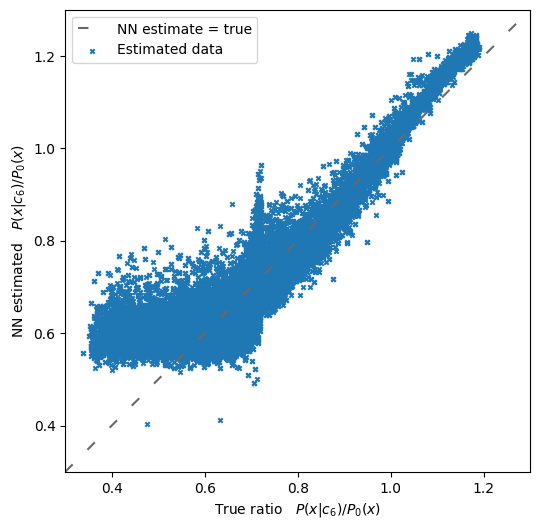

In [54]:
lnspc = np.linspace(0.3,1.3)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label=f'Estimated data')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.3,1.3)
plt.ylim(0.3,1.3)
plt.legend()

plt.show()

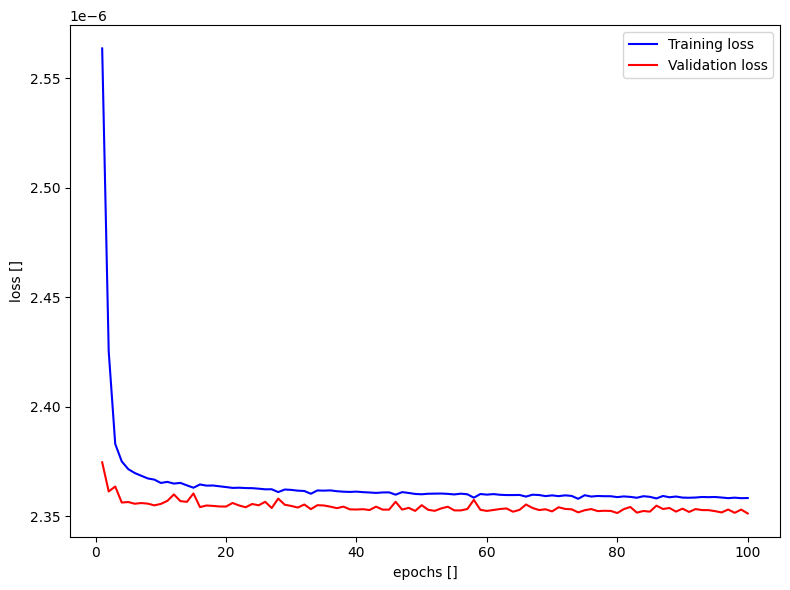

In [55]:
hist_prm = ''

with open(os.path.join(JOBS_DIR, config['output_dir'], 'history.txt'), 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,t_loss_prm.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()